In [318]:
import seaborn
import pandas as pd
import itertools
import numpy as np
from matplotlib import pyplot as plt
import re

In [454]:
def four_element_parser(line):
    
    count = int(line.split()[0])
    origin_x, origin_y, origin_z = [float(each) for each in line.split()[1:4]]
    
    return count, origin_x, origin_y, origin_z

def atom_parser(line):
    
    count = int(line.split()[0])
    origin_x, origin_y, origin_z = [float(each) for each in line.split()[2:5]]
    
    return count, origin_x, origin_y, origin_z
    
    

def read_cube(filename):
    with open(filename) as fptr:
        filecontent = fptr.readlines()
    
    #obtain constants
    title = " ".join(filecontent[0:2])
    atom_count, origin_x, origin_y, origin_z = four_element_parser(filecontent[2])
    
    voxel_X_count, X_d1, X_d2, X_d3 = four_element_parser(filecontent[3])
    voxel_Y_count, Y_d1, Y_d2, Y_d3 = four_element_parser(filecontent[4])
    voxel_Z_count, Z_d1, Z_d2, Z_d3 = four_element_parser(filecontent[5])
    
    ## tuple format: (atomic number, x, y, z)
    atom_list = []
    for atom_line in filecontent[6:6+atom_count]:
        atom_list.append(atom_parser(atom_line))
      
    
    ## parsing density
    LINEBREAK= int(voxel_Z_count / 6) + 1
    print(LINEBREAK)
    
    
    density = []
    newline = []
    for i,line in enumerate(filecontent[6+atom_count:]):
        newline += map(float, line.split())
        if (i % LINEBREAK == LINEBREAK-1):
            density.append(newline)
            newline = []

    spatial_density = []
    newline = []
    
    for i,Z_line in enumerate(density):
        newline.append(Z_line)
 
        if (i % voxel_Y_count == voxel_Y_count-1):
            spatial_density.append(newline)
            newline = []

    origin = (origin_x, origin_y, origin_z)
    Xd = (X_d1, X_d2, X_d3)
    Yd = (Y_d1, Y_d2, Y_d3)
    Zd = (Z_d1, Z_d2, Z_d3)
    
    return origin, Xd, Yd, Zd, atom_list, np.array(spatial_density)



def compute_density(density, coordinate, radius, sphere=False):
    xC,yC,zC=coordinate
    
    densitylist = []
    for x in range(-radius+xC, radius+1+xC):
        for y in range(-radius+yC, radius+1+yC):
            for z in range(-radius+zC, radius+1+zC):
                if not sphere:
                    densitylist.append(density[x,y,z])
                elif ((x-xC)**2 + (y-yC)**2 + (z-zC)**2 <= radius*radius):
                    densitylist.append(density[x,y,z])
                    
    return densitylist
    
    

In [490]:
project_name="Fe_MePy2tacn_CH3CN_OTf_2_nmr"
origin, Xd, Yd, Zd, atoms, density = read_cube(project_name + ".cube")

22


In [478]:
np.sum(density)

53.343853967598

In [491]:
def output_spinden(density, atom_list, radius):
    density_list = []
    for each in atom_list:
        atom_num, x, y, z = atoms[each-1]
        relative_xyz = np.linalg.solve(np.array([Xd, Yd, Zd]), np.subtract((x,y,z), origin))
        
        density_list.append(compute_density(density, 
                                            (int(relative_xyz[0]), int(relative_xyz[1]), int(relative_xyz[2])), 
                                                 radius=radius, sphere=True))
    return density_list

def read_log(filename, index, inputlist):
    log_density_list = []
    #dirty trick to obtain the atom's Fermi contact table
    with open(filename) as fptr:
        fermi_flag=False
        i=0
        for line in fptr:
            if ("Fermi" not in line) and (fermi_flag is False):
                continue
            elif (fermi_flag is False):
                fermi_flag=True
                fptr.readline()
                continue
                
                
            if (fermi_flag is True) and (len(line.split())==6):
                if int(line.split()[0]) in inputlist:
                    log_density_list.append(float(line.split()[index]))
            else:
                fermi_flag = False
    
    return np.array(log_density_list).flatten()
        
def obtain_target(atomic_number, atoms):
    target_atoms=[]
    #order number of target atoms, start from 1
    
    for i, each in enumerate(atoms):
        if (each[0] == atomic_number):
            target_atoms.append(i+1)
    
    return target_atoms
    

Text(0, 0.5, 'averaged density')

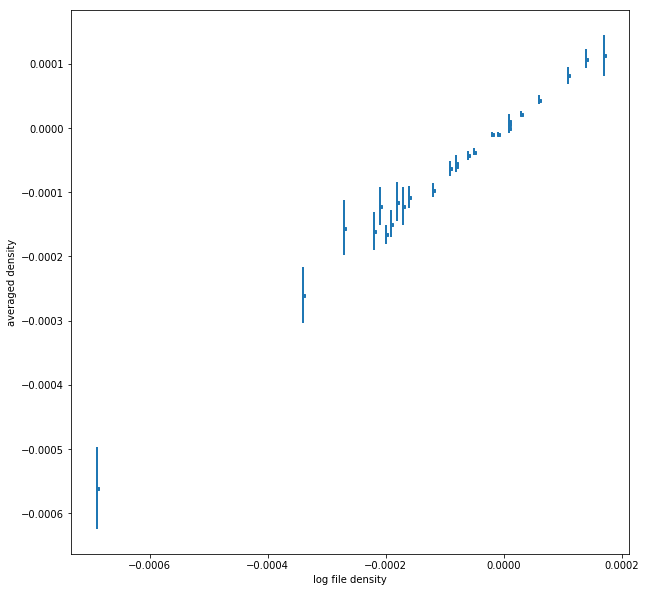

In [499]:
##proton list for n4py
# H_list=[5,8,10,12,14,17,18,21,23,25,27,31,33,35,37,40,41,44,46,48,50]
H_list=obtain_target(atomic_number=1, atoms=atoms)
H_list.remove(27)

chk_density = np.array(output_spinden(density, H_list, radius=1))
log_density =read_log(project_name + ".gjf.log", index=2, inputlist=H_list)
# chk_density.shape
plt.gcf().set_size_inches(10, 10)

plt.errorbar(log_density, np.mean(chk_density, axis=1), yerr=np.std(chk_density,axis=1), 
             ls='none', marker='s', markersize=3, elinewidth=2)
plt.xlabel("log file density")
plt.ylabel("averaged density")


In [500]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.mean(chk_density,axis=1).reshape(-1,1), log_density)
reg.coef_
# reg.intercept_ 

array([1.29073283])